In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as cmo
from scipy.interpolate import griddata
from datetime import datetime, timedelta
import gsw
import datetime
import cartopy.crs as ccrs
from pathlib import Path
import cmasher as cmr
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from skimage.morphology import dilation
from skimage.morphology import disk
xr.set_options(keep_attrs=True)
plt.rcParams['font.size']=14

In [42]:
path_in=Path('/home/birte/observation/MR_region/')
ds=xr.open_mfdataset('/home/birte/observation/MR_region/5mbins_depth300/binned/EN4_MR_grid_201[6,7]*.nc')
ds

<xarray.Dataset>
Dimensions:   (N_PROF: 769, depth: 401)
Coordinates:
  * N_PROF    (N_PROF) int64 3749 3750 3751 3752 3753 ... 4514 4515 4516 4517
  * depth     (depth) int64 0 5 10 15 20 25 30 ... 1975 1980 1985 1990 1995 2000
Data variables:
    T_grided  (N_PROF, depth) float64 dask.array<chunksize=(364, 401), meta=np.ndarray>
    S_grided  (N_PROF, depth) float64 dask.array<chunksize=(364, 401), meta=np.ndarray>
    lat       (N_PROF) float64 dask.array<chunksize=(364,), meta=np.ndarray>
    lon       (N_PROF) float64 dask.array<chunksize=(364,), meta=np.ndarray>
    time      (N_PROF) datetime64[ns] dask.array<chunksize=(364,), meta=np.ndarray>

In [47]:
ds.coords['month']=ds.time.dt.month
ds.coords['year']=ds.time.dt.year
ds.coords['day']=ds.time.dt.day
#ds_en4.coords['time']=ds_en4.time
ds['sig0']=gsw.sigma0(ds.S_grided,ds.T_grided)
# estimate MLD
ds['mld']=ds.depth.where((ds.sig0.isel(depth=slice(11,None,None))-ds.sig0.isel(depth=2))>=0.01).min(dim='depth')
# find Tmax below MLD
ds=ds.where(~np.isnan(ds.mld),drop=True)


# Bathymetry
bat=xr.open_dataset('/home/birte/MAUD_RISE_config/maud_v4/m12_mask/1_domain_cfg_50levels_new.nc')
bat.coords['nav_lon']=bat.nav_lon
bat.coords['nav_lat']=bat.nav_lat

/home/birte/anaconda3/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


/home/birte/anaconda3/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/birte/anaconda3/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/birte/anaconda3/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/birte/anaconda3/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarn

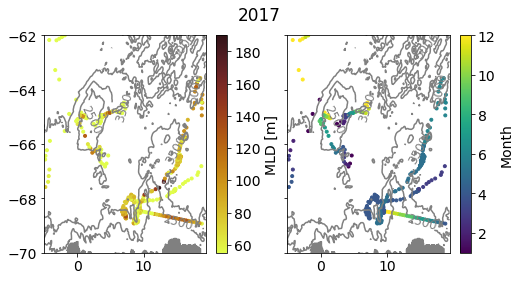

In [51]:
year=2017
fig,axes=plt.subplots(1,2,figsize=(8,4))
ax=axes[0]
cb=bat.bathy_meter.plot.contour(x="nav_lon",y="nav_lat",levels=[0,2500,3500,5000],ax=ax,colors='gray')
bat.bathy_meter.where(bat.bathy_meter<1).isel(x=slice(4,-4),y=slice(10,-10)).plot.contourf(x="nav_lon",y="nav_lat",colors='gray',ax=ax,add_colorbar=False)
c=ax.scatter(ds.lon.where(ds.year==year),ds.lat.where(ds.year==year),c=ds.mld.where(ds.year==year),cmap=cmo.solar_r,marker='.')
plt.colorbar(c,ax=ax,label='MLD [m]')
ax.set_xlabel('')
ax.set_ylabel('')
ax.clabel(cb,fmt = '%2.0f', fontsize=12)
ax.set_ylim(-70,-62)

ax=axes[1]
cb=bat.bathy_meter.plot.contour(x="nav_lon",y="nav_lat",levels=[0,2500,3500,5000],ax=ax,colors='gray')
bat.bathy_meter.where(bat.bathy_meter<1).isel(x=slice(4,-4),y=slice(10,-10)).plot.contourf(x="nav_lon",y="nav_lat",colors='gray',ax=ax,add_colorbar=False)
c=ax.scatter(ds.lon.where(ds.year==year),ds.lat.where(ds.year==year),c=ds.month.where(ds.year==year),cmap='viridis',marker='.')
plt.colorbar(c,ax=ax,label='Month')
ax.set_xlabel('')
ax.set_yticklabels('')
ax.set_ylabel('')
ax.clabel(cb,fmt = '%2.0f', fontsize=12)
ax.set_ylim(-70,-62)
plt.suptitle(f'{year}')
#plt.xlim(bat.nav_lon.isel(x_c=4,y_c=4),bat.nav_lon.isel(x_c=-11,y_c=-4))
#plt.title('all years')
plt.savefig(f'./Obs_mld_{year}.jpg',dpi=300)